PS: this code was copied "as it was" from [here][1]. Obviously, it is not configured and the notebook output are not correct. See the beforementioned link for more details.

[1]: https://stanford.edu/~boyd/papers/prox_algs/finance.html


In [1]:
function h = finance

Continuation prompt found - input was incomplete:
function h = finance


Problem data

In [2]:
s = RandStream.create('mt19937ar','seed',0);
RandStream.setDefaultStream(s);

n = 20;
T = 15;

% risk model
F  = randn(n);
S  = F*F';
d  = abs(randn(n,1));
gam = 1;

% return model
mu = randn(n,1);

% t-cost model
kappa = unifrnd(0,3,n,1);

f = @(u) -mu'*u + (gam/2)*quad_form(u,S);
g = @(u) kappa'*pow_pos(abs(u), 1.5);

error: 'RandStream' undefined near line 1, column 1

The 'RandStream' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.
error: 'RandStream' undefined near line 1, column 1

The 'RandStream' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.
error: 'unifrnd' undefined near line 1, column 1

The 'unifrnd' function belongs to the statistics package from Octave
Forge which seems to not be installed in your system.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.


## CVX (static)

In [3]:
tic
cvx_begin quiet
    variable xs(n)
    minimize(f(xs))
    subject to
        sum(xs) <= 1
        xs >= 0
cvx_end
h.xs = xs;
toc

error: 'cvx_begin' undefined near line 1, column 1
error: 'variable' undefined near line 1, column 1
error: 'xs' undefined near line 1, column 1
error: 'subject' undefined near line 1, column 1
error: 'xs' undefined near line 1, column 1
error: 'xs' undefined near line 1, column 1
error: 'cvx_end' undefined near line 1, column 1
error: 'xs' undefined near line 1, column 1
Elapsed time is 0.0523801 seconds.


## CVX (dynamic)

In [5]:
tic
cvx_begin quiet
    cvx_solver sdpt3
    variable x(n,T)
    expression obj
    obj = f(x(:,1));
    for t = 2:T
        obj = obj + f(x(:,t)) + g(x(:,t) - x(:,t-1));
    end
    minimize(obj)
    subject to
        sum(x) <= 1
        x >= 0
        x(:,1) == 0;
        x(:,T) == 0;
cvx_end
toc

p_cvx = cvx_optval;

error: 'cvx_begin' undefined near line 1, column 1
error: 'cvx_solver' undefined near line 1, column 1
error: 'variable' undefined near line 1, column 1
error: 'expression' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'obj' undefined near line 2, column 2
error: 'obj' undefined near line 1, column 1
error: 'subject' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'cvx_end' undefined near line 1, column 1
Elapsed time is 0.0806251 seconds.
error: 'cvx_optval' undefined near line 1, column 1


## Plots

error: 'x' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1


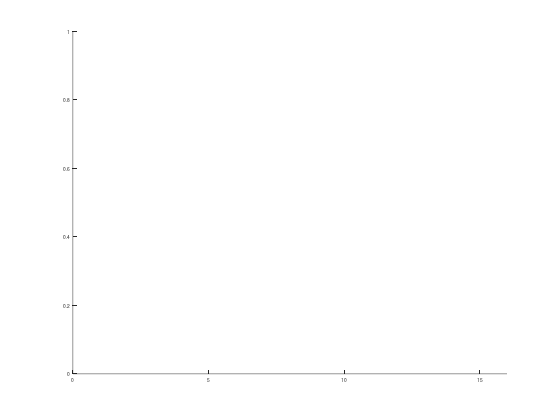

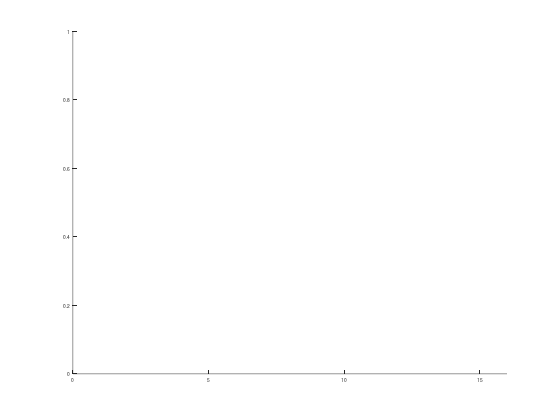

In [7]:
figure(1);
plot(x', 'LineWidth', 2);
xlim([0 T+1]);
print -depsc fin_asset_holdings.eps;

figure(2);
bar(norms(x - repmat(xs,1,T), 1));
xlim([0 T+1]);
print -depsc fin_deviation.eps;

## ADMM

In [9]:
MAX_ITER = 100;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

lambda = 1;

x = zeros(n,T);
z = zeros(n,T);
u = zeros(n,T);

fprintf('\n\n%3s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
    'r norm', 'eps pri', 's norm', 'eps dual');

for k = 1:MAX_ITER

    % x-update
    for t = 2:T-1
        cvx_begin quiet
            variable xt(n)
            minimize(f(xt) + (1/(2*lambda))*sum_square(xt - z(:,t) + u(:,t)))
            subject to
                xt >= 0
                sum(xt) <= 1
        cvx_end
        x(:,t) = xt;
    end

    % z-update
    zold = z;
    cvx_begin quiet
        cvx_solver sdpt3
        variable z(n,T)
        obj = 0;
        for t = 2:T
            obj = obj + g(z(:,t)-z(:,t-1));
        end
        minimize(obj + (1/(2*lambda))*square_pos(norm(z - x - u,'fro')))
        subject to
            z(:,1) == 0;
    cvx_end

    % u-update
    u = u + x - z;

    % diagnostics, reporting, termination checks
    h.r_norm(k)   = norm(x - z,'fro');
    h.s_norm(k)   = norm(-(z - zold)./lambda,'fro');
    h.eps_pri(k)  = sqrt(n*T)*ABSTOL + RELTOL*max(norm(x,'fro'), norm(-z,'fro'));
    h.eps_dual(k) = sqrt(n*T)*ABSTOL + RELTOL*norm(u./lambda,'fro');

    h.objval(k)   = f(x(:,1));
    for t = 2:T
        h.objval(k) = h.objval(k) + f(x(:,t)) + g(x(:,t) - x(:,t-1));
    end

    fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\n', k, ...
        h.r_norm(k), h.eps_pri(k), h.s_norm(k), h.eps_dual(k));

    if h.r_norm(k) < h.eps_pri(k) && h.s_norm(k) < h.eps_dual(k)
         break;
    end

end

h.admm_iter = k;
h.x_admm = x;
h.mu = mu;



iter	    r norm	   eps pri	    s norm	  eps dual


error: 'cvx_begin' undefined near line 5, column 5


## Plots

error: structure has no member 'objval'


error: 'p_cvx' undefined near line 1, column 1


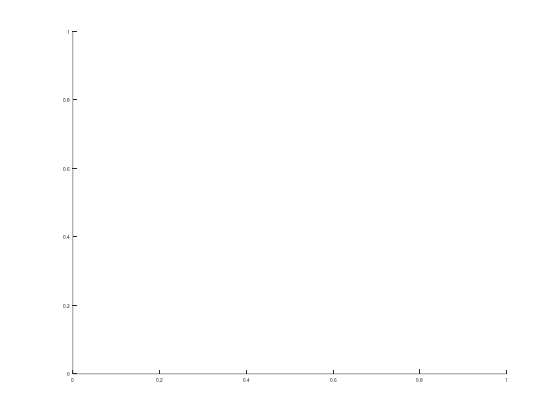

In [11]:
figure(3);
hold on;
plot(h.objval');
plot(repmat(p_cvx, 1, k), 'k--');
print -depsc fin_optval.eps;